Lets use MAMS dataset

In [29]:
import warnings
warnings.filterwarnings("ignore")

In [30]:
import os

try:
    # Running as normal Python script inside src/
    this_file = os.path.abspath(__file__)
    src_root = os.path.dirname(this_file)                        # EMOTION-PRED/src
    project_root = os.path.dirname(src_root)                    # EMOTION-PRED/
except NameError:
    # Running inside Jupyter (likely src/notebooks or src/)
    cwd = os.getcwd()

    # If running inside src/notebooks → go up one level
    if cwd.endswith("notebooks"):
        src_root = os.path.abspath(os.path.join(cwd, ".."))
        project_root = os.path.dirname(src_root)
    else:
        # Running from project root directly
        project_root = cwd
        src_root = os.path.join(project_root, "src")

# Final unified paths
results_root = os.path.join(src_root, "results")
data_root = os.path.join(src_root, "data","MAMS-ACSA","raw","data_jsonl")
print(f"📂 Project root: {project_root}"
      f"\n📂 Source root: {src_root}"
      f"\n📂 Results root: {results_root}"
      f"\n📂 Data root: {data_root}")

📂 Project root: /home/daniel-tesfai/Desktop/EMOTION-PRED
📂 Source root: /home/daniel-tesfai/Desktop/EMOTION-PRED/src
📂 Results root: /home/daniel-tesfai/Desktop/EMOTION-PRED/src/results
📂 Data root: /home/daniel-tesfai/Desktop/EMOTION-PRED/src/data/MAMS-ACSA/raw/data_jsonl


In [31]:
import os
import json
import pandas as pd

# Dataset name
dataset_name = "MAMS-ACSA"

# ----------------------------------------------------------
# 1. Paths
# ----------------------------------------------------------
input_path = os.path.join(data_root, "train.jsonl")

# ----------------------------------------------------------
# 2. ALWAYS load JSONL (no CSV caching)
# ----------------------------------------------------------
print("Loading JSONL and flattening aspects...")

records = []

with open(input_path, "r", encoding="utf-8") as f:
    for line in f:
        if not line.strip():
            continue

        obj = json.loads(line)
        sentence = obj["input"]

        for item in obj["output"]:
            records.append({
                "sentence": sentence,
                "aspect_term": item.get("aspect", ""),
                "polarity": item.get("polarity", ""),
                "emotion": item.get("emotion", None),
            })

# Convert to DataFrame
df = pd.DataFrame(records)

# Add row_id
df["row_id"] = df.index

# Reorder columns
df = df[["row_id", "sentence", "aspect_term", "polarity", "emotion"]]

print("✔ Loaded JSONL → DataFrame")
print(df.head())

# df is now ready to send directly to annotate_model()

Loading JSONL and flattening aspects...
✔ Loaded JSONL → DataFrame
   row_id  \
0       0   
1       1   
2       2   
3       3   
4       4   

                                                                                                                                                          sentence  \
0  It might be the best sit down food I've had in the area, so if you are going to the upright citizen brigade, or the garden, it could be just the place for you.   
1  It might be the best sit down food I've had in the area, so if you are going to the upright citizen brigade, or the garden, it could be just the place for you.   
2                                                                           Hostess was extremely accommodating when we arrived an hour early for our reservation.   
3                                                                           Hostess was extremely accommodating when we arrived an hour early for our reservation.   
4                  We we

In [32]:
import sys, os

# Add src/ to Python path
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

In [33]:
import os
import re
import json
import pandas as pd
from emotion_pipeline_optimized import run_full_emotion_pipeline, results_root, MODEL_NAMES

dataset_name = "MAMS-ACSA"

# ----------------------------------------------------------
# 1. Paths
# ----------------------------------------------------------
# data_root must already be defined in your notebook / env
input_path = os.path.join(data_root, "train.jsonl")
output_dir = os.path.join(results_root, f"emotion_{dataset_name}")
os.makedirs(output_dir, exist_ok=True)

# ----------------------------------------------------------
# 2. Detect which models are already done
# ----------------------------------------------------------
existing_files = set(os.listdir(output_dir))
missing_models = []

for model_name in MODEL_NAMES:
    safe = re.sub(r"[^a-zA-Z0-9]", "_", model_name)
    expected_jsonl = f"{safe}_annotated.jsonl"

    if expected_jsonl in existing_files:
        print(f"✔ Found existing output for: {model_name}  ({expected_jsonl})")
    else:
        print(f"✖ No output yet for:       {model_name}")
        missing_models.append(model_name)

if not missing_models:
    print("\n✅ All models already have JSONL outputs. Pipeline not run.")
else:
    print("\n➡ Will run pipeline for these models only:")
    for m in missing_models:
        print("   -", m)

    # ------------------------------------------------------
    # 3. Load JSONL and flatten aspects ONCE
    # ------------------------------------------------------
    print("\nLoading JSONL and flattening aspects...")

    records = []
    with open(input_path, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            obj = json.loads(line)
            sentence = obj["input"]
            for item in obj["output"]:
                records.append({
                    "sentence": sentence,
                    "aspect_term": item.get("aspect", ""),
                    "polarity": item.get("polarity", ""),
                    "emotion": item.get("emotion", None),
                })

    df = pd.DataFrame(records)
    df["row_id"] = df.index
    df = df[["row_id", "sentence", "aspect_term", "polarity", "emotion"]]

    print("✔ Loaded JSONL → DataFrame")
    print(df.head())

    # ------------------------------------------------------
    # 4. Run FULL PIPELINE for missing models only
    # ------------------------------------------------------
    run_full_emotion_pipeline(
        df=df,
        model_names=missing_models,
        dataset_name=dataset_name,
        results_root=results_root,
    )

✔ Found existing output for: j-hartmann/emotion-english-distilroberta-base  (j_hartmann_emotion_english_distilroberta_base_annotated.jsonl)
✔ Found existing output for: j-hartmann/emotion-english-roberta-large  (j_hartmann_emotion_english_roberta_large_annotated.jsonl)
✔ Found existing output for: nateraw/bert-base-uncased-emotion  (nateraw_bert_base_uncased_emotion_annotated.jsonl)
✔ Found existing output for: joeddav/distilbert-base-uncased-go-emotions-student  (joeddav_distilbert_base_uncased_go_emotions_student_annotated.jsonl)
✔ Found existing output for: cardiffnlp/twitter-roberta-base-emotion  (cardiffnlp_twitter_roberta_base_emotion_annotated.jsonl)
✔ Found existing output for: mrm8488/t5-base-finetuned-emotion  (mrm8488_t5_base_finetuned_emotion_annotated.jsonl)
✔ Found existing output for: SamLowe/roberta-base-go_emotions  (SamLowe_roberta_base_go_emotions_annotated.jsonl)

✅ All models already have JSONL outputs. Pipeline not run.


In [34]:
import os
import json
import pandas as pd

RESULT_DIR = os.path.join(results_root, f"emotion_{dataset_name}")
jsonl_files = [f for f in os.listdir(RESULT_DIR) if f.endswith(".jsonl")]

MODEL_NAME_MAP = {
    "j_hartmann_emotion_english_roberta_large": "roberta_large",
    "nateraw_bert_base_uncased_emotion": "bert_base_emotion",
    "j_hartmann_emotion_english_distilroberta_base": "roberta_emotion",
    "joeddav_distilbert_base_uncased_go_emotions_student": "go_emotions",
    "cardiffnlp_twitter_roberta_base_emotion": "tweet_eval",
    "mrm8488_t5_base_finetuned_emotion": "t5_emotion",
    "samlowe_roberta_base_go_emotions": "go_emotions_roberta",
}

# -----------------------------------------------------------
# Load grouped JSONL
# -----------------------------------------------------------
def load_grouped_jsonl(path):
    with open(path, "r", encoding="utf-8") as f:
        return [json.loads(line) for line in f if line.strip()]

# -----------------------------------------------------------
# Flatten JSONL into rows
# sentence | aspect | model_column
# -----------------------------------------------------------
def flatten_group(records, model_column_name):
    rows = []
    for item in records:
        sentence = item["input"]
        for out in item["output"]:
            rows.append({
                "sentence": sentence,
                "aspect": out["aspect"],
                model_column_name: out["emotion"]
            })
    return pd.DataFrame(rows)

# -----------------------------------------------------------
# MERGE ALL MODELS
# -----------------------------------------------------------
merged = None

for f in jsonl_files:
    full_path = os.path.join(RESULT_DIR, f)

    base = f.replace("_annotated.jsonl", "").lower()
    model_col = MODEL_NAME_MAP.get(base, base)

    recs = load_grouped_jsonl(full_path)
    df_flat = flatten_group(recs, model_col)

    if merged is None:
        merged = df_flat
    else:
        merged = merged.merge(df_flat, on=["sentence", "aspect"], how="inner")

pd.set_option("display.max_colwidth", None)
print(merged.head(2))

                                                                                                                                                            sentence  \
0  $25 prix fixe sounds like a good deal, but dinner was still $100 for two, the portions were small, and the ($35) wine, clearly where the money is made, mediocre.   
1  $25 prix fixe sounds like a good deal, but dinner was still $100 for two, the portions were small, and the ($35) wine, clearly where the money is made, mediocre.   

          aspect bert_base_emotion t5_emotion go_emotions_roberta  \
0          price           sadness        joy             neutral   
1  miscellaneous           sadness        joy             neutral   

  roberta_large go_emotions roberta_emotion tweet_eval  
0       neutral   confusion         neutral      anger  
1       neutral   confusion         neutral      anger  


In [35]:
import pandas as pd

# -------------------------------------------------------
# 1) MODEL COLUMNS THAT ACTUALLY EXIST IN MERGED
# -------------------------------------------------------
model_cols = [
    "roberta_large",
    "bert_base_emotion",
    "roberta_emotion",
    "go_emotions",
    "tweet_eval",
    "t5_emotion",
    "go_emotions_roberta",
]

# only keep those that exist in merged
model_cols = [c for c in model_cols if c in merged.columns]

print("Using model columns:", model_cols)

# -------------------------------------------------------
# 2) MAJORITY VOTE
# -------------------------------------------------------
def get_majority_emotion(row):
    votes = [row[col] for col in model_cols if pd.notna(row[col])]

    if not votes:
        return None

    counts = {}
    for emo in votes:
        counts[emo] = counts.get(emo, 0) + 1

    # pick label with max count
    return max(counts.items(), key=lambda x: x[1])[0]

merged["consensus_emotion"] = merged.apply(get_majority_emotion, axis=1)

# -------------------------------------------------------
# 3) CONSENSUS COUNT
# -------------------------------------------------------
def get_consensus_count(row):
    emo = row["consensus_emotion"]
    if emo is None or pd.isna(emo):
        return 0

    return sum(1 for col in model_cols if col in merged.columns and row[col] == emo)

merged["consensus_count"] = merged.apply(get_consensus_count, axis=1)

# -------------------------------------------------------
# 4) DISPLAY SAFE PREVIEW
# -------------------------------------------------------
preview_cols = ["sentence", "aspect"] + model_cols + ["consensus_emotion", "consensus_count"]
print(merged[preview_cols].head(1))

Using model columns: ['roberta_large', 'bert_base_emotion', 'roberta_emotion', 'go_emotions', 'tweet_eval', 't5_emotion', 'go_emotions_roberta']
                                                                                                                                                            sentence  \
0  $25 prix fixe sounds like a good deal, but dinner was still $100 for two, the portions were small, and the ($35) wine, clearly where the money is made, mediocre.   

  aspect roberta_large bert_base_emotion roberta_emotion go_emotions  \
0  price       neutral           sadness         neutral   confusion   

  tweet_eval t5_emotion go_emotions_roberta consensus_emotion  consensus_count  
0      anger        joy             neutral           neutral                3  


In [36]:
# ----------------------------------------------------------
# SAFE CONSENSUS EMOTION DISTRIBUTION
# ----------------------------------------------------------
consensus_valid = merged["consensus_emotion"].dropna()

consensus_counts = consensus_valid.value_counts()
print("=== Consensus Emotion Distribution ===")
print(consensus_counts)
print()

consensus_percent = (consensus_valid.value_counts(normalize=True) * 100).round(2)
print("=== Consensus Emotion Distribution (%) ===")
print(consensus_percent)
print()

# ----------------------------------------------------------
# Build full statistics table
# ----------------------------------------------------------
consensus_stats = pd.DataFrame({
    "count": consensus_counts,
    "percent": consensus_percent,
}).sort_values("count", ascending=False)

print("=== Consensus Statistics ===")
print(consensus_stats)
print()

# ----------------------------------------------------------
# CONSENSUS STRENGTH: how many models agreed
# ----------------------------------------------------------
strength_counts = merged["consensus_count"].value_counts().sort_index()

print("=== Consensus Strength (Number of Models Agreeing) ===")
print(strength_counts)

=== Consensus Emotion Distribution ===
consensus_emotion
neutral           3804
anger             1332
joy               1248
disgust            305
sadness            164
surprise           133
fear                71
love                24
disappointment       5
amusement            2
confusion            1
excitement           1
Name: count, dtype: int64

=== Consensus Emotion Distribution (%) ===
consensus_emotion
neutral           53.65
anger             18.79
joy               17.60
disgust            4.30
sadness            2.31
surprise           1.88
fear               1.00
love               0.34
disappointment     0.07
amusement          0.03
confusion          0.01
excitement         0.01
Name: proportion, dtype: float64

=== Consensus Statistics ===
                   count  percent
consensus_emotion                
neutral             3804    53.65
anger               1332    18.79
joy                 1248    17.60
disgust              305     4.30
sadness              164

In [37]:
print("=== Per-model emotion counts ===\n")

# Keep only model columns that exist in merged
valid_model_cols = [col for col in model_cols if col in merged.columns]

if not valid_model_cols:
    print("❌ No model emotion columns found in `merged`.")
else:
    for col in valid_model_cols:
        print(f"Model: {col}")
        print(merged[col].value_counts(dropna=True))
        print("-" * 40)

=== Per-model emotion counts ===

Model: roberta_large
roberta_large
neutral     5042
anger        677
disgust      617
joy          288
surprise     225
sadness      134
fear         107
Name: count, dtype: int64
----------------------------------------
Model: bert_base_emotion
bert_base_emotion
joy         4015
anger       2015
sadness      585
fear         234
love         163
surprise      78
Name: count, dtype: int64
----------------------------------------
Model: roberta_emotion
roberta_emotion
neutral     4449
disgust     1427
anger        443
joy          346
surprise     230
sadness      103
fear          92
Name: count, dtype: int64
----------------------------------------
Model: go_emotions
go_emotions
caring            2578
annoyance          769
confusion          686
disappointment     520
realization        494
excitement         373
desire             345
curiosity          178
surprise           147
relief             141
disapproval        122
nervousness        107
a

In [38]:
# ----------------------------------------------------------
# 1. Keep only model columns that actually exist
# ----------------------------------------------------------
valid_model_cols = [col for col in model_cols if col in merged.columns]

if not valid_model_cols:
    raise ValueError("No valid model columns found in merged dataset!")

# ----------------------------------------------------------
# 2. Build emotion frequency matrix
# ----------------------------------------------------------
stats = {}

for col in valid_model_cols:
    freq = merged[col].value_counts(dropna=True)
    stats[col] = freq

# Combine into a single DataFrame
stats_df = pd.DataFrame(stats).fillna(0).astype(int)

print("=== Emotion frequency per model (rows = emotions, columns = models) ===")
print(stats_df)

# ----------------------------------------------------------
# 3. Consensus distribution
# ----------------------------------------------------------
print("\n=== Consensus label distribution ===")
print(merged["consensus_emotion"].dropna().value_counts())

=== Emotion frequency per model (rows = emotions, columns = models) ===
                roberta_large  bert_base_emotion  roberta_emotion  \
admiration                  0                  0                0   
amusement                   0                  0                0   
anger                     677               2015              443   
annoyance                   0                  0                0   
approval                    0                  0                0   
caring                      0                  0                0   
confusion                   0                  0                0   
curiosity                   0                  0                0   
desire                      0                  0                0   
disappointment              0                  0                0   
disapproval                 0                  0                0   
disgust                   617                  0             1427   
embarrassment               0  

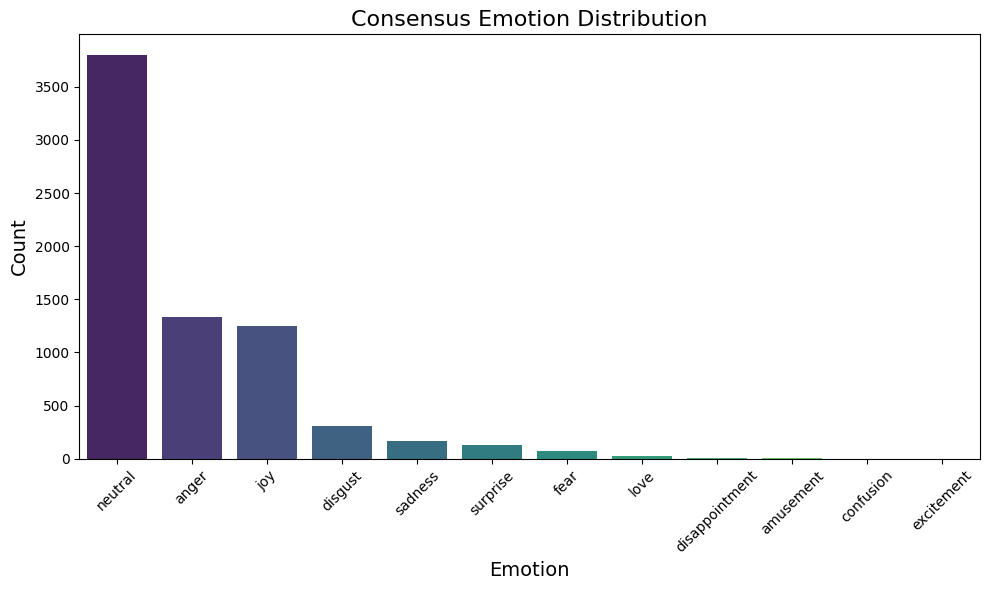

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop rows with no consensus emotion
consensus = merged["consensus_emotion"].dropna()

# Compute counts once
counts = consensus.value_counts()
order = counts.index  # sorted by frequency

plt.figure(figsize=(10, 6))

sns.barplot(
    x=order,
    y=counts[order].values,
    palette="viridis"
)

plt.title("Consensus Emotion Distribution", fontsize=16)
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

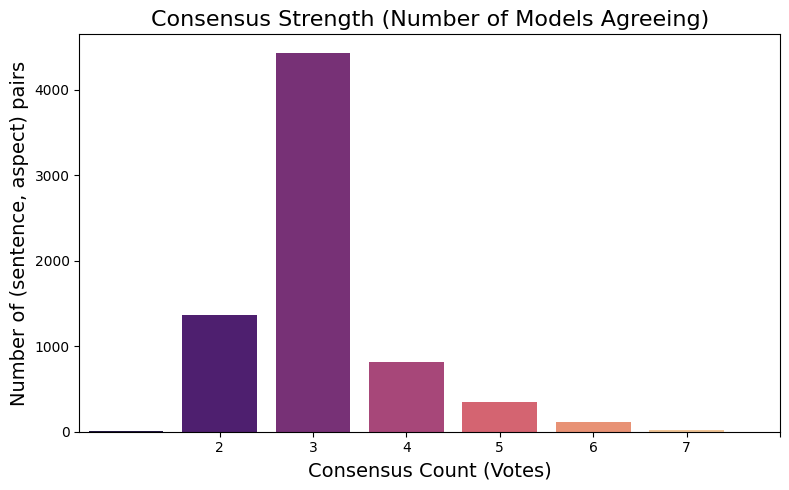

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Drop any NaNs just in case
strength = merged["consensus_count"].dropna().value_counts().sort_index()

plt.figure(figsize=(8, 5))

sns.barplot(
    x=strength.index.astype(int),
    y=strength.values,
    palette="magma"
)

plt.title("Consensus Strength (Number of Models Agreeing)", fontsize=16)
plt.xlabel("Consensus Count (Votes)", fontsize=14)
plt.ylabel("Number of (sentence, aspect) pairs", fontsize=14)
plt.xticks(strength.index.astype(int))
plt.tight_layout()
plt.show()

Original merged shape: (7090, 11)
New merged_final shape: (7090, 11)
=== BEFORE (Consensus Emotion Distribution) ===
consensus_emotion
neutral           3804
anger             1332
joy               1248
disgust            305
sadness            164
surprise           133
fear                71
love                24
disappointment       5
amusement            2
confusion            1
excitement           1
Name: count, dtype: int64

=== AFTER (Final 7-Class Emotion Distribution) ===
emotion_final
neutral     3804
anger       1337
joy         1275
disgust      305
sadness      164
surprise     134
fear          71
Name: count, dtype: int64

Unmapped labels: []


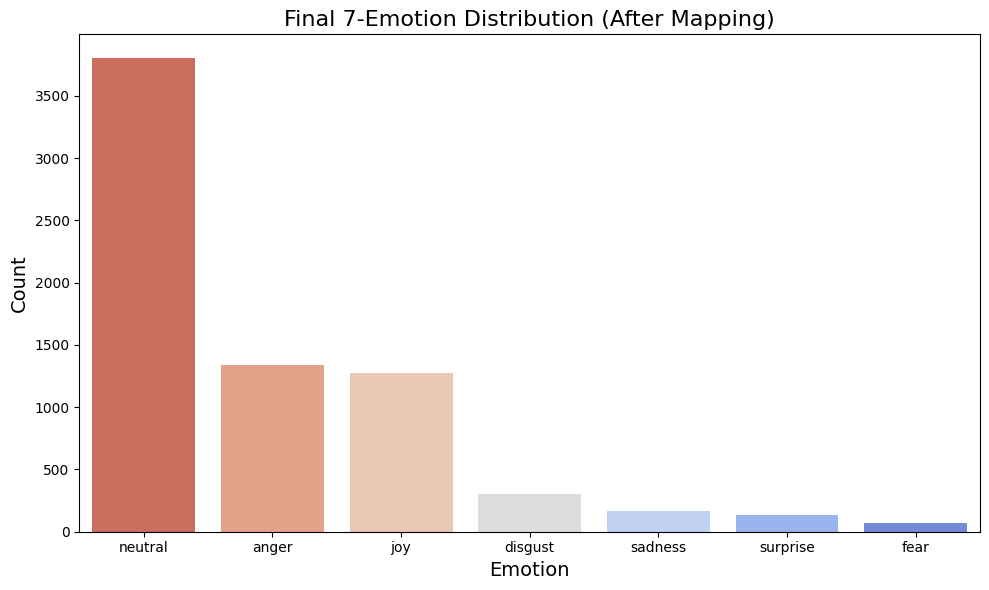

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ----------------------------------------------------
# 1. Make a full copy before remapping
# ----------------------------------------------------
merged_final = merged.copy()
print("Original merged shape:", merged.shape)
print("New merged_final shape:", merged_final.shape)

# ----------------------------------------------------
# 2. Define final emotion set
# ----------------------------------------------------
FINAL_EMOTIONS = [
    "neutral", "anger", "joy", "sadness", "fear", "surprise", "disgust"
]

# ----------------------------------------------------
# 3. Fine-grained → Basic emotion mapping
# ----------------------------------------------------
emotion_mapping = {
    # Joy cluster
    "joy": "joy",
    "amusement": "joy",
    "excitement": "joy",
    "optimism": "joy",
    "gratitude": "joy",
    "pride": "joy",
    "love": "joy",
    "admiration": "joy",
    "approval": "joy",
    "caring": "joy",
    "desire": "joy",

    # Anger cluster
    "anger": "anger",
    "annoyance": "anger",
    "disapproval": "anger",
    "disappointment": "anger",  # Could be sadness; restaurant domain fits anger

    # Sadness cluster
    "sadness": "sadness",
    "remorse": "sadness",
    "embarrassment": "sadness",

    # Fear cluster
    "fear": "fear",
    "nervousness": "fear",

    # Surprise cluster
    "surprise": "surprise",
    "realization": "surprise",
    "confusion": "surprise",

    # Disgust cluster
    "disgust": "disgust",
    "repulsion": "disgust",

    # Neutral
    "neutral": "neutral",
}

# Safety fallback: unmapped → neutral
def map_final_label(x):
    return emotion_mapping.get(x, "neutral")

# ----------------------------------------------------
# 4. Apply mapping
# ----------------------------------------------------
merged_final["emotion_final"] = merged_final["consensus_emotion"].apply(map_final_label)

# ----------------------------------------------------
# 5. BEFORE → AFTER distributions
# ----------------------------------------------------
print("=== BEFORE (Consensus Emotion Distribution) ===")
print(merged_final["consensus_emotion"].value_counts())

print("\n=== AFTER (Final 7-Class Emotion Distribution) ===")
print(merged_final["emotion_final"].value_counts())

# ----------------------------------------------------
# 6. Check if any labels were not mapped
# ----------------------------------------------------
unmapped = merged_final[
    ~merged_final["consensus_emotion"].isin(emotion_mapping.keys())
]["consensus_emotion"].unique()

print("\nUnmapped labels:", unmapped)

# Should output: []


# ----------------------------------------------------
# 7. Visualization of final 7-class distribution
# ----------------------------------------------------
plt.figure(figsize=(10, 6))
sns.barplot(
    x=merged_final["emotion_final"].value_counts().index,
    y=merged_final["emotion_final"].value_counts().values,
    palette="coolwarm_r"
)

plt.title("Final 7-Emotion Distribution (After Mapping)", fontsize=16)
plt.xlabel("Emotion", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.tight_layout()
plt.show()

In [42]:
from emotion_pipeline_new import annotate
df = pd.DataFrame({
    "sentence": ["Service was slow but the staff were very friendly."],
    "aspect_term": [["service", "staff"]]
})

preds = annotate(df)
for key, value in preds.items():
    print(f"{key}: {value}")

ModuleNotFoundError: No module named 'emotion_pipeline_new'

In [ ]:
from transformers import pipeline

model_name = "cardiffnlp/twitter-roberta-base-emotion"
pipe = pipeline("text-classification", model=model_name, tokenizer=model_name)

texts = [
    "[ASPECT] service [SENTENCE] Service was slow but the staff were very friendly.",
    "[ASPECT] staff [SENTENCE] Service was slow but the staff were very friendly."
]

pipe(texts)